In [1]:
# # Preamble

# ## Import colours

# In[1]:
# Lists of colors for plots

c0 = (0.76, 0.76, 0.76)
c1 = (1.00, 0.18, 0.33);
c2 = (1.00, 0.23, 0.19);
c3 = (1.00, 0.58, 0.00);
c4 = (1.00, 0.80, 0.00);
c5 = (0.30, 0.85, 0.39);
c6 = (0.35, 0.78, 0.98);
c7 = (0.20, 0.67, 0.86);
c8 = (0.00, 0.48, 1.00);
c9 = (0.35, 0.34, 0.84);
c10 = (0.00, 0.31, 0.57);
c11 = (0.12, 0.29, 0.69);
c12 = (0.17, 0.17, 0.42);
c13 = (1.00, 1.00, 1.00);
c14 = (0.77, 0.04, 0.00);

ios_colors=[c5, c1, c3, c7, c2, c6, c4, c9, c8]

def to_rgb_frac(vect):
    return (float(vect[0])/255, float(vect[1])/255, float(vect[2])/255)

color_list=list(map(to_rgb_frac, [(166,206,227),(178,223,138),(51,160,44),(31,120,180)]))

# Lists of colors for plots

def to_rgb_frac(vect):
    return (float(vect[0])/255, float(vect[1])/255, float(vect[2])/255)

rb_div_5=list(map(to_rgb_frac, [(202,0,32),
(244,165,130),
(247,247,247),
(146,197,222),
(5,113,176)]))

qualitative_10=list(map(to_rgb_frac, [(166,206,227),
(31,120,180),
(178,223,138),
(51,160,44),
(251,154,153),
(227,26,28),  #orange
(253,191,111), #orange
(255,127,0),
(202,178,214),
(106,61,154)]))


# <img src="Qualitative_10.png">
# <img src="RB_DIV_5.png">



# ## Import packages

# In[2]:
# from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import interp1d
import time

#from __future__ import print_function
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

# imported packages
get_ipython().run_line_magic('matplotlib', 'inline')
import datetime
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import math
import matplotlib.ticker as plticker
import bisect
import copy
import json
import csv
import ast
import pylab as pl
import time
#import urllib2
#import io
#import os
#import re




# # Define useful functions for the simulations

# + Each mutation has an ID (ID) and a growth advantage (s) as a tuple
# ``[(ID1, s1)]``
# + Each clone contains a certain number of mutations, so could be defined as a list of the mutation, fitness effect tuples
# ``[(ID1, s1),(ID2, s2)....]``
# + Each clone also needs an associated size (n) (e.g. 50 cells) -> ``[[(ID1, s1),(ID2, s2)....], n]``
# + Total population is a list of the different clones (with a different set of mutations within it): ``[[[(ID1, s1),(ID2, s2)....], n], [[(ID1, s1),(ID2, s2)....], n]]]``

# In[18]:


# define function 'divide'
def divide(clone_info, dt, B0, D0):  
    #dt = a small interval of time, 
    #D0 = symmetric rate to differentiated
    #B0 = symmetric rate to self renewal
    #B  = modified birth rate including fitness advantage
    
    mutations=clone_info[0] # [(ID1, s1)]
#     print('muts =',mutations)
    clone_size=clone_info[1] # n
#     print('clone_size =',clone_size)
    fitness_effects=[i[1] for i in mutations]
    F=sum(fitness_effects)
#     print('F=',F)
    B = B0*(1.0+F) #B = birth rate, which is 1 + the overall fitness effect of the mutations within a particular clone
    number_of_births = np.random.poisson(clone_size*B*dt) #pulls a random number from the Poisson distribution with/
    #mean of clone_size x birth rate x interval of time
#     print('number of births = ', number_of_births)
    number_of_deaths = np.random.poisson(clone_size*D0*dt)
#     print('number of deaths = ', number_of_deaths)
    new_clone_size = clone_size + number_of_births - number_of_deaths
    return [mutations, new_clone_size]


# In[19]:


#define function 'mutation_fitness' of the form:
# sb=0.05 #beneficial fitness effect
# sd=0.00 #deleterious fitness effect
# Pb=2/3 #probability of beneficial fitness effect
# Pn=1/3 #probability of neutral fitness effect
# Pd=0.00 #probability of deleterious fitness effect
# DFE = [[sd, Pd], [0.0, Pn], [sb, Pb]] #distribution of fitness effects doesn't need to be normalized (because normalized in function below)
def mutation_fitness(DFE):
    total_prob=sum([i[1] for i in DFE])
    normalized_DFE=[[i[0], i[1]/total_prob] for i in DFE]
    
    random_number=np.random.random()
    cumulative = 0.0
    for [s,P] in normalized_DFE:
        cumulative = cumulative+P
        if random_number<cumulative:
            fitness_effect=s
            break
    return fitness_effect
        


# In[20]:


#define function 'mutate'
def mutate(clone_info, dt, u, last_mutation_ID, DFE): #u=mutation rate
    mutations=clone_info[0] #(ID, s)
    clone_size=clone_info[1]
    number_of_mutations = np.random.poisson(clone_size*u*dt)
#     print("number of mutations =", number_of_mutations)
    list_of_new_clones=[]
    for i in range(number_of_mutations):
        last_mutation_ID = last_mutation_ID+1
#         print("last mutation ID =", last_mutation_ID)
        new_fitness_effect = mutation_fitness(DFE)
#         print("new fitness effect =", new_fitness_effect)
        new_clone = [mutations+[(last_mutation_ID, new_fitness_effect)],1]
#         print("new clone =", new_clone)
        list_of_new_clones.append(new_clone)
#         print("list of new clones =", list_of_new_clones)
    return (list_of_new_clones, last_mutation_ID)
    


# In[21]:
#define function 'sequence'
def sequence(pop, mean_depth):
    N=pop_size(pop)
    variant_dict={}
    list_of_variants=[]
    
    #first determine total freq of variant across all clones and record clones in which it arises
    for (clone1, size) in pop:
        if len(clone1)>1: #ensures non-WT clones only
            clone=copy.deepcopy(clone1)
            clone.pop(0)
            
            for mutation in clone:
                
                #update mutations frequency
                mID=mutation[0]
                if mID in variant_dict:
                    #true_freq=variant_dict[mID]['true_freq']+0.5*(size/N)
                    #variant_dict[mID]['true_freq']=true_freq
                    true_size=variant_dict[mID]['true_size']+size
                    variant_dict[mID]['true_size']=true_size
                else:
                    #variant_dict[mID]={'true_freq':0.5*(size/N)}
                    variant_dict[mID]={'true_size':size}
                    #mutation type    
                    if mutation[1]>0.0:
                        mutation_type="n" # non-synonymous
                    elif mutation[1]==0.0:
                        mutation_type="s" #synonymous
                    variant_dict[mID]['mutation_type']=mutation_type
                    
    for m, e in variant_dict.items():
        
        mutation_type=e['mutation_type']
        #true_freq=e['true_freq']
        true_size=e['true_size']
        

        #depth1 = int(mean_depth*np.exp(np.random.normal(0.0, .3)))
        #expected_reads1=true_freq*depth1
        #reads1=np.random.poisson(expected_reads1)
        depth1=0
        reads1=0

        #depth2 = int(mean_depth*np.exp(np.random.normal(0.0, .3)))
        #expected_reads2=true_freq*depth2
        #reads2=np.random.poisson(expected_reads2)
        depth2=0
        reads2=0

        #if reads1<4:
         #   reads1=0
        #if reads2<4:
         #   reads2=0

        #freq1=reads1/depth1
        #freq2=reads2/depth2
        freq1=0
        freq2=0

        list_of_variants.append({"mutation_ID":m,                                  "mutation_type":mutation_type,                                  "true_size": true_size,                                  "freq1":freq1,                                 "reads1":reads1,                                  "depth1": depth1,                                  "freq2":freq2,                                 "reads2":reads2,                                  "depth2": depth2
                                })
    return list_of_variants     



#define function 'pop_size'
def pop_size(pop):
    total=0
    for clone in pop:
        sub_pop_size=clone[-1]
        total=total+sub_pop_size
    return total        

    


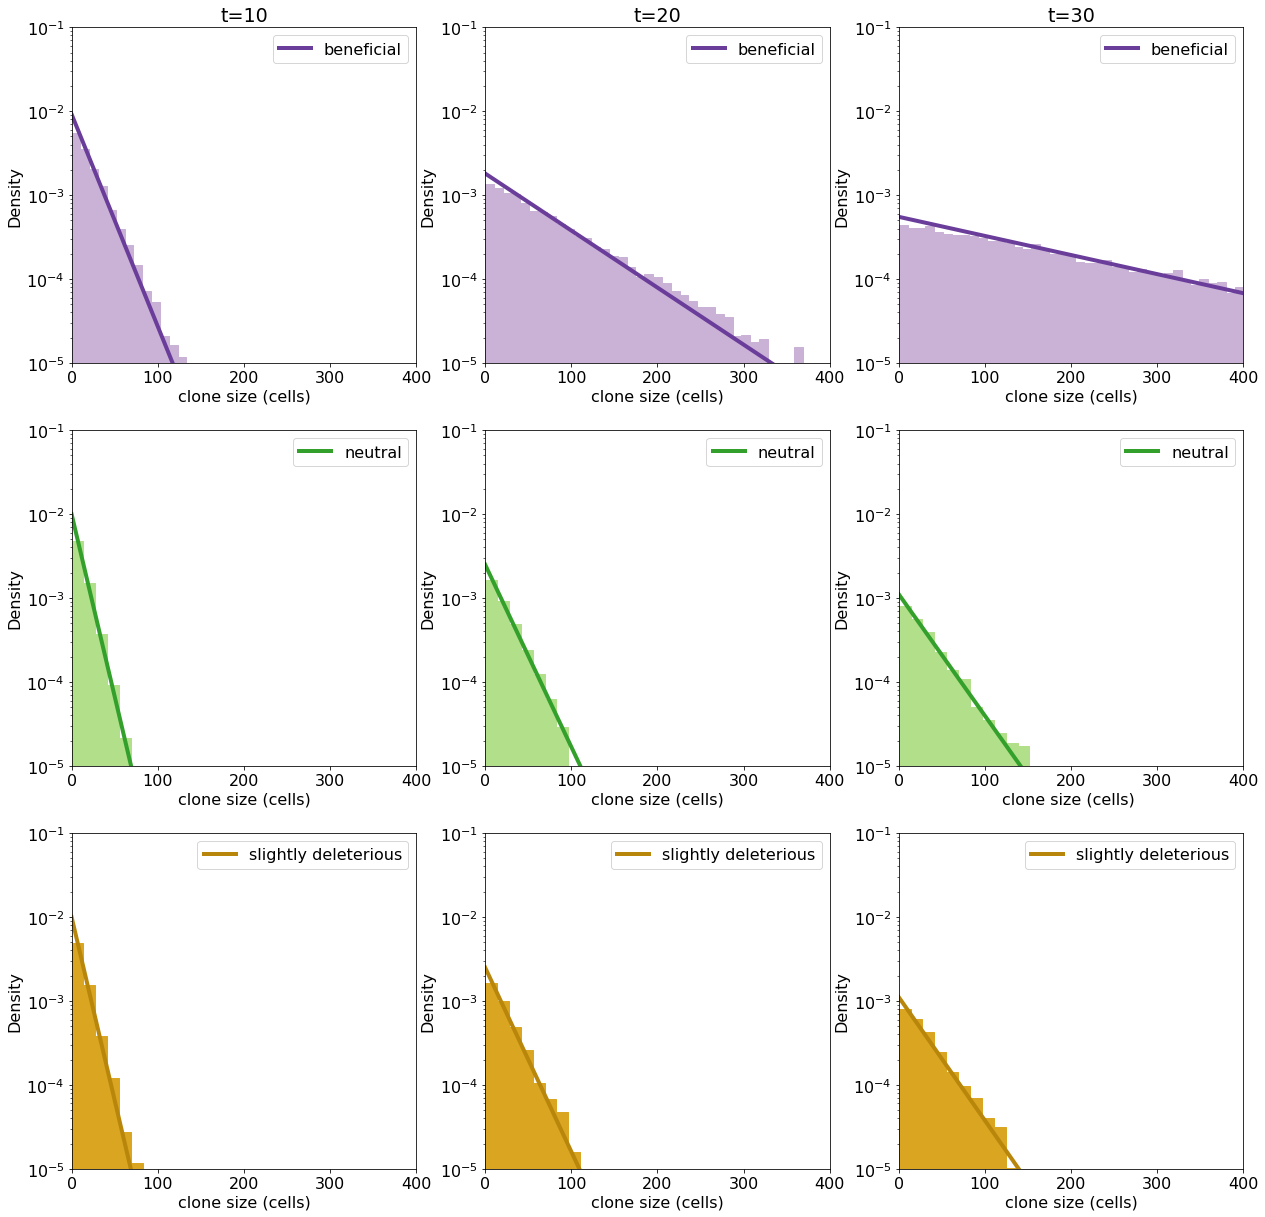

In [3]:
def to_rgb_frac(vect):
    return (float(vect[0])/255, float(vect[1])/255, float(vect[2])/255)

color_list=list(map(to_rgb_frac, [(166,206,227),(178,223,138),(51,160,44),(31,120,180)]))

# Lists of colors for plots

def to_rgb_frac(vect):
    return (float(vect[0])/255, float(vect[1])/255, float(vect[2])/255)

rb_div_5=list(map(to_rgb_frac, [(202,0,32),
(244,165,130),
(247,247,247),
(146,197,222),
(5,113,176)]))

qualitative_10=list(map(to_rgb_frac, [(166,206,227),
(31,120,180),
(178,223,138),
(51,160,44),
(251,154,153),
(227,26,28),
(253,191,111),
(255,127,0),
(202,178,214),
(106,61,154)]))

import datetime
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import math
import matplotlib.ticker as plticker
import bisect
import copy
import json
import csv
import ast
import pylab as pl
import time
# <img src="Qualitative_10.png">
# <img src="RB_DIV_5.png">


plt.clf()
plt.close('all')
f, ax1 = plt.subplots(3, 3, figsize=(21,7*3))
font = {'weight' : 'normal','size'   : 16}
matplotlib.rc('font', **font)

def density(n, r, t, Delta):
    
    if n<r/Delta**2:
        result=u*(2*3.1415)**0.5*(r/n**3)**0.25*np.exp(r*t-2*(n*r)**0.5)
    else:
        result=((u*r/n)*np.exp(r*(t-1/Delta)-n*Delta)*(1-np.exp(-(n*Delta**2-r)/Delta))/(n*Delta**2-r))
    
    
    return (result)


vector_of_first_mutant_60='single_mutant_s_0.1_runs_150000_age10.csv'
vector_of_first_mutant_90='single_mutant_s_0.1_runs_150000_age20.csv'
vector_of_first_mutant_120='single_mutant_s_0.1_runs_150000_age30.csv'


#alpha=0
number_of_individuals=150000
s=0.1

#plots of the theory and simulations combined



first_mutant_60=[]
first_mutant_90=[]
first_mutant_120=[]
with open(vector_of_first_mutant_60) as data:
    reader = csv.reader(data,delimiter=',')
    next(reader, None)   #skips header
    for row in reader:
        try:            
            clone_size= float(row[1])
        except: # catch the error    
        #except IndexError: # catch the error
                pass # pass will basically ignore it
         # and execution will continue on to whatever comes
         # after the try/except block
        #print((row[1]))
        first_mutant_60.append(clone_size)     
        
with open(vector_of_first_mutant_90) as data:
    reader = csv.reader(data,delimiter=',')
    next(reader, None)   #skips header
    for row in reader:
        try:            
            clone_size= float(row[1])
        except: # catch the error    
        #except IndexError: # catch the error
                pass # pass will basically ignore it
         # and execution will continue on to whatever comes
         # after the try/except block
        #print((row[1]))
        first_mutant_90.append(clone_size)     
        
with open(vector_of_first_mutant_120) as data:
    reader = csv.reader(data,delimiter=',')
    next(reader, None)   #skips header
    for row in reader:
        try:            
            clone_size= float(row[1])
        except: # catch the error    
        #except IndexError: # catch the error
                pass # pass will basically ignore it
         # and execution will continue on to whatever comes
         # after the try/except block
        #print((row[1]))
        first_mutant_120.append(clone_size)          
        

    
first_mutant_60=list(filter(lambda a: a != 0.0, first_mutant_60))
first_mutant_90=list(filter(lambda a: a != 0.0, first_mutant_90))
first_mutant_120=list(filter(lambda a: a != 0.0, first_mutant_120))

            
lfirst_mutant_60=np.log(np.array(first_mutant_60))  
lfirst_mutant_90=np.log(np.array(first_mutant_90))
lfirst_mutant_120=np.log(np.array(first_mutant_120))  
    
all_data=[first_mutant_60, first_mutant_90,first_mutant_120]
all_log_data=[lfirst_mutant_60, lfirst_mutant_90,lfirst_mutant_120]



major_ticks = np.log(np.array([10**k for k in range(6)]))                                         
major_tick_labels= ["$10^{%s}$" % k for k in range(6)]


#linear binning : same bins and limits in the same simulation with same alpha
n_bins=40
xmin=0
xmax=400
binwidth=(xmax-xmin)/(n_bins-1)
ymin=10**-5
#1/(number_of_individuals*binwidth)
ymax=0.1


historam_data=[np.histogram(dat,bins=np.linspace(xmin, xmax, n_bins)) for dat in all_data]
densities=np.array([[c/(number_of_individuals*binwidth) for c in h[0]] for h in historam_data])
bin_positions=np.array([[(h[1][i]+h[1][i+1])/2 for i in range(len(h[1])-1)] for h in historam_data])

linear_clone_size=np.array(np.linspace(xmin, xmax, 1000))

#log binning : same bins and limits in the same simulation with same alpha
# n_bins=100
# xmin=np.log(1)
# xmax=np.log(10500)
# binwidth=(xmax-xmin)/n_bins
# ymin=1/(number_of_individuals*binwidth)
# ymax=10**2

# log_historam_data=[np.histogram(dat,bins=np.linspace(xmin, xmax, n_bins)) for dat in all_log_data]
# densities_log=np.array([[c/(number_of_individuals*binwidth) for c in h[0]] for h in log_historam_data])
# bin_positions_log=np.array([[(h[1][i]+h[1][i+1])/2 for i in range(len(h[1])-1)] for h in log_historam_data])

# log_clone_size=np.log(linear_clone_size)




#Plot 1
t=10
tilde_n=(np.exp(s*t)-1)/s
density_theory= [np.exp(s*t)*np.exp(-n/tilde_n)/tilde_n**2 for n in linear_clone_size]

#green: go for 2,3
ax1[0][0].bar(bin_positions[0],densities[0], width=binwidth, zorder=0, color=qualitative_10[8], edgecolor=qualitative_10[8])
#ax1[0][0].plot(linear_clone_size, density_theory_linear, color=qualitative_10[9], lw=4, zorder=1, label='deleterious')
ax1[0][0].plot(linear_clone_size, density_theory, color=qualitative_10[9], lw=4, zorder=1, label='beneficial')
ax1[0][0].legend()
ax1[0][0].set_yscale('log')
ax1[0][0].set_xscale('linear')
ax1[0][0].set_ylabel('Density')
ax1[0][0].set_xlabel('clone size (cells)')
ax1[0][0].set_title('t=10')
ax1[0][0].set_xlim(xmin, xmax)
ax1[0][0].set_ylim(ymin, ymax) 
ax1[0][0].margins(x=0)




#Plot 2
t=20

tilde_n=(np.exp(s*t)-1)/s
density_theory= [np.exp(s*t)*np.exp(-n/tilde_n)/tilde_n**2 for n in linear_clone_size]

ax1[0][1].bar(bin_positions[1],densities[1], width=binwidth, color=qualitative_10[8], edgecolor=qualitative_10[8])
#ax1[1][0].plot(linear_clone_size, density_theory_linear, color=qualitative_10[9], lw=4, zorder=1, label='deleterious')
ax1[0][1].plot(linear_clone_size, density_theory, color=qualitative_10[9], lw=4, zorder=1, label='beneficial')
ax1[0][1].legend()
ax1[0][1].set_yscale('log')
ax1[0][1].set_xscale('linear')
ax1[0][1].set_ylabel('Density')
ax1[0][1].set_xlabel('clone size (cells)')
ax1[0][1].set_title('t=20')
ax1[0][1].set_xlim(xmin, xmax)
ax1[0][1].set_ylim(ymin, ymax)  
ax1[0][1].margins(x=0)




#Plot 3
t=30

tilde_n=(np.exp(s*t)-1)/s
density_theory= [np.exp(s*t)*np.exp(-n/tilde_n)/tilde_n**2 for n in linear_clone_size]

ax1[0][2].bar(bin_positions[2],densities[2], width=binwidth, color=qualitative_10[8], edgecolor=qualitative_10[8])
#ax1[2][0].plot(linear_clone_size, density_theory_linear, color=qualitative_10[9], lw=4, zorder=1, label='deterministic')
ax1[0][2].plot(linear_clone_size, density_theory, color=qualitative_10[9], lw=4, zorder=1, label='beneficial')
ax1[0][2].legend()
ax1[0][2].set_yscale('log')
ax1[0][2].set_xscale('linear')
ax1[0][2].set_ylabel('Density')
ax1[0][2].set_xlabel('clone size (cells)')
ax1[0][2].set_title('t=30')
ax1[0][2].set_xlim(xmin, xmax)
ax1[0][2].set_ylim(ymin, ymax)                                           
#ax1[2][0].set_xticks(major_ticks);                                                                                            
#ax1[2][0].set_xticklabels(major_tick_labels);
ax1[0][2].margins(x=0)


vector_of_first_mutant_60='single_mutant_s_10minus7_runs_50000_age10.csv'
vector_of_first_mutant_90='single_mutant_s_10minus7_runs_50000_age20.csv'
vector_of_first_mutant_120='single_mutant_s_10minus7_runs_50000_age30.csv'


#alpha=-1
number_of_individuals=50000
s=0

#plots of the theory and simulations combined



first_mutant_60=[]
first_mutant_90=[]
first_mutant_120=[]
with open(vector_of_first_mutant_60) as data:
    reader = csv.reader(data,delimiter=',')
    next(reader, None)   #skips header
    for row in reader:
        try:            
            clone_size= float(row[1])
        except: # catch the error    
        #except IndexError: # catch the error
                pass # pass will basically ignore it
         # and execution will continue on to whatever comes
         # after the try/except block
        #print((row[1]))
        first_mutant_60.append(clone_size)     
        
with open(vector_of_first_mutant_90) as data:
    reader = csv.reader(data,delimiter=',')
    next(reader, None)   #skips header
    for row in reader:
        try:            
            clone_size= float(row[1])
        except: # catch the error    
        #except IndexError: # catch the error
                pass # pass will basically ignore it
         # and execution will continue on to whatever comes
         # after the try/except block
        #print((row[1]))
        first_mutant_90.append(clone_size)     
        
with open(vector_of_first_mutant_120) as data:
    reader = csv.reader(data,delimiter=',')
    next(reader, None)   #skips header
    for row in reader:
        try:            
            clone_size= float(row[1])
        except: # catch the error    
        #except IndexError: # catch the error
                pass # pass will basically ignore it
         # and execution will continue on to whatever comes
         # after the try/except block
        #print((row[1]))
        first_mutant_120.append(clone_size)          
        

    
first_mutant_60=list(filter(lambda a: a != 0.0, first_mutant_60))
first_mutant_90=list(filter(lambda a: a != 0.0, first_mutant_90))
first_mutant_120=list(filter(lambda a: a != 0.0, first_mutant_120))

            
lfirst_mutant_60=np.log(np.array(first_mutant_60))  
lfirst_mutant_90=np.log(np.array(first_mutant_90))
lfirst_mutant_120=np.log(np.array(first_mutant_120))  
    
all_data=[first_mutant_60, first_mutant_90,first_mutant_120]
all_log_data=[lfirst_mutant_60, lfirst_mutant_90,lfirst_mutant_120]

#linear binning : same bins and limits in the same simulation with same alpha
n_bins=30

binwidth=(xmax-xmin)/(n_bins-1)



historam_data=[np.histogram(dat,bins=np.linspace(xmin, xmax, n_bins)) for dat in all_data]
densities=np.array([[c/(number_of_individuals*binwidth) for c in h[0]] for h in historam_data])
bin_positions=np.array([[(h[1][i]+h[1][i+1])/2 for i in range(len(h[1])-1)] for h in historam_data])

linear_clone_size=np.array(np.linspace(xmin, xmax, 1000))

#log binning : same bins and limits in the same simulation with same alpha
# n_bins=100
# xmin=np.log(1)
# xmax=np.log(10500)
# ymin=1/(number_of_individuals*binwidth)
# ymax=10**2
# binwidth=(xmax-xmin)/(n_bins-1)

log_historam_data=[np.histogram(dat,bins=np.linspace(xmin, xmax, n_bins)) for dat in all_log_data]
densities_log=np.array([[c/(number_of_individuals*binwidth) for c in h[0]] for h in log_historam_data])
bin_positions_log=np.array([[(h[1][i]+h[1][i+1])/2 for i in range(len(h[1])-1)] for h in log_historam_data])

log_clone_size=np.array(np.linspace(xmin, xmax, 1000))


#Plot 1
t=10

c=1
tilde_n=c*t
density_theory= [np.exp(0)*np.exp(-n/tilde_n)/tilde_n**2 for n in linear_clone_size]

ax1[1][0].bar(bin_positions[0],densities[0], width=binwidth, zorder=0, color=qualitative_10[2], edgecolor=qualitative_10[2])
ax1[1][0].plot(linear_clone_size, density_theory, color=qualitative_10[3], lw=4, zorder=1, label='neutral')
#ax1[0][1].plot(log_clone_size, density_theory_log, color=qualitative_10[9], lw=4, zorder=1, label='')
ax1[1][0].legend()
ax1[1][0].set_yscale('log')
ax1[1][0].set_xscale('linear')
ax1[1][0].set_ylabel('Density')
ax1[1][0].set_xlabel('clone size (cells)')
#ax1[0][1].set_title('t=10')
ax1[1][0].set_xlim(xmin, xmax)
ax1[1][0].set_ylim(ymin, ymax) 
ax1[1][0].margins(x=0)




#Plot 2
t=20

c=1
tilde_n=c*t
density_theory= [np.exp(0)*np.exp(-n/tilde_n)/tilde_n**2 for n in linear_clone_size]

ax1[1][1].bar(bin_positions[1],densities[1], width=binwidth, color=qualitative_10[2], edgecolor=qualitative_10[2])
ax1[1][1].plot(linear_clone_size, density_theory, color=qualitative_10[3], lw=4, zorder=1, label='neutral')
#ax1[1][1].plot(log_clone_size, density_theory_log, color=qualitative_10[9], lw=4, zorder=1, label='')
ax1[1][1].legend()
ax1[1][1].set_yscale('log')
ax1[1][1].set_xscale('linear')
ax1[1][1].set_ylabel('Density')
ax1[1][1].set_xlabel('clone size (cells)')
#ax1[1][1].set_title('t=20')
ax1[1][1].set_xlim(xmin, xmax)
ax1[1][1].set_ylim(ymin, ymax)  
ax1[1][1].margins(x=0)




#Plot 3
t=30

c=1
tilde_n=c*t
density_theory= [np.exp(0)*np.exp(-n/tilde_n)/tilde_n**2 for n in linear_clone_size]

ax1[1][2].bar(bin_positions[2],densities[2], width=binwidth, color=qualitative_10[2], edgecolor=qualitative_10[2])
ax1[1][2].plot(linear_clone_size, density_theory, color=qualitative_10[3], lw=4, zorder=1, label='neutral')
#ax1[2][1].plot(log_clone_size, density_theory_log, color=qualitative_10[9], lw=4, zorder=1, label='')
ax1[1][2].legend()
ax1[1][2].set_yscale('log')
ax1[1][2].set_xscale('linear')
ax1[1][2].set_ylabel('Density')
ax1[1][2].set_xlabel('clone size (cells) ')
#ax1[2][1].set_title('t=30')
ax1[1][2].set_xlim(xmin, xmax)
ax1[1][2].set_ylim(ymin, ymax)                                           
#ax1[2][0].set_xticks(major_ticks);                                                                                            
#ax1[2][0].set_xticklabels(major_tick_labels);
ax1[1][2].margins(x=0)



vector_of_first_mutant_60='single_mutant_s_minus0.001_runs_50000_age10.csv'
vector_of_first_mutant_90='single_mutant_s_minus0.001_runs_50000_age20.csv'
vector_of_first_mutant_120='single_mutant_s_minus0.001_runs_50000_age30.csv'


#alpha=-0.5
number_of_individuals=50000
s=-0.001

#plots of the theory and simulations combined

first_mutant_60=[]
first_mutant_90=[]
first_mutant_120=[]

with open(vector_of_first_mutant_60) as data:
    reader = csv.reader(data,delimiter=',')
    next(reader, None)   #skips header
    for row in reader:
        try:            
            clone_size= float(row[1])
        except: # catch the error    
        #except IndexError: # catch the error
                pass # pass will basically ignore it
         # and execution will continue on to whatever comes
         # after the try/except block
        #print((row[1]))
        first_mutant_60.append(clone_size)     
        
with open(vector_of_first_mutant_90) as data:
    reader = csv.reader(data,delimiter=',')
    next(reader, None)   #skips header
    for row in reader:
        try:            
            clone_size= float(row[1])
        except: # catch the error    
        #except IndexError: # catch the error
                pass # pass will basically ignore it
         # and execution will continue on to whatever comes
         # after the try/except block
        #print((row[1]))
        first_mutant_90.append(clone_size)     
        
with open(vector_of_first_mutant_120) as data:
    reader = csv.reader(data,delimiter=',')
    next(reader, None)   #skips header
    for row in reader:
        try:            
            clone_size= float(row[1])
        except: # catch the error    
        #except IndexError: # catch the error
                pass # pass will basically ignore it
         # and execution will continue on to whatever comes
         # after the try/except block
        #print((row[1]))
        first_mutant_120.append(clone_size)          
        

    
first_mutant_60=list(filter(lambda a: a != 0.0, first_mutant_60))
first_mutant_90=list(filter(lambda a: a != 0.0, first_mutant_90))
first_mutant_120=list(filter(lambda a: a != 0.0, first_mutant_120))

            
lfirst_mutant_60=np.log(np.array(first_mutant_60))  
lfirst_mutant_90=np.log(np.array(first_mutant_90))
lfirst_mutant_120=np.log(np.array(first_mutant_120))  
    
all_data=[first_mutant_60, first_mutant_90,first_mutant_120]
all_log_data=[lfirst_mutant_60, lfirst_mutant_90,lfirst_mutant_120]

#linear binning : same bins and limits in the same simulation with same alpha
n_bins=30

binwidth=(xmax-xmin)/(n_bins-1)



historam_data=[np.histogram(dat,bins=np.linspace(xmin, xmax, n_bins)) for dat in all_data]
densities=np.array([[c/(number_of_individuals*binwidth) for c in h[0]] for h in historam_data])
bin_positions=np.array([[(h[1][i]+h[1][i+1])/2 for i in range(len(h[1])-1)] for h in historam_data])

linear_clone_size=np.array(np.linspace(xmin, xmax, 1000))

#log binning : same bins and limits in the same simulation with same alpha
# n_bins=100
# xmin=np.log(1)
# xmax=np.log(10500)
# binwidth=(xmax-xmin)/n_bins
# ymin=1/(number_of_individuals*binwidth)
# ymax=10**2

log_historam_data=[np.histogram(dat,bins=np.linspace(xmin, xmax, n_bins)) for dat in all_log_data]
densities_log=np.array([[c/(number_of_individuals*binwidth) for c in h[0]] for h in log_historam_data])
bin_positions_log=np.array([[(h[1][i]+h[1][i+1])/2 for i in range(len(h[1])-1)] for h in log_historam_data])

log_clone_size=np.array(np.linspace(xmin, xmax, 1000))






#Plot 1
t=10
tilde_n=(np.exp(s*t)-1)/s
density_theory= [np.exp(s*t)*np.exp(-n/tilde_n)/tilde_n**2 for n in linear_clone_size]

ax1[2][0].bar(bin_positions[0],densities[0], width=binwidth, zorder=0, color='goldenrod', edgecolor='goldenrod')
ax1[2][0].plot(linear_clone_size, density_theory, color='darkgoldenrod', lw=4, zorder=1, label='slightly deleterious')
#ax1[0][2].plot(log_clone_size, density_theory_log, color=qualitative_10[9], lw=4, zorder=1, label='')
ax1[2][0].legend()
ax1[2][0].set_yscale('log')
ax1[2][0].set_xscale('linear')
ax1[2][0].set_ylabel('Density')
ax1[2][0].set_xlabel('clone size (cells)')
#ax1[0][2].set_title('t=10')
ax1[2][0].set_xlim(xmin, xmax)
ax1[2][0].set_ylim(ymin, ymax) 
ax1[2][0].margins(x=0)




#Plot 2
t=20
tilde_n=(np.exp(s*t)-1)/s
density_theory= [np.exp(s*t)*np.exp(-n/tilde_n)/tilde_n**2 for n in linear_clone_size]

ax1[2][1].bar(bin_positions[1],densities[1], width=binwidth, color='goldenrod', edgecolor='goldenrod')
ax1[2][1].plot(linear_clone_size, density_theory, color='darkgoldenrod', lw=4, zorder=1, label='slightly deleterious')
#ax1[1][2].plot(log_clone_size, density_theory_log, color=qualitative_10[9], lw=4, zorder=1, label='')
ax1[2][1].legend()
ax1[2][1].set_yscale('log')
ax1[2][1].set_xscale('linear')
ax1[2][1].set_ylabel('Density')
ax1[2][1].set_xlabel('clone size (cells)')
#ax1[1][2].set_title('t=20')
ax1[2][1].set_xlim(xmin, xmax)
ax1[2][1].set_ylim(ymin, ymax)  
ax1[2][1].margins(x=0)




#Plot 3
t=30

tilde_n=(np.exp(s*t)-1)/s
density_theory= [np.exp(s*t)*np.exp(-n/tilde_n)/tilde_n**2 for n in linear_clone_size]

ax1[2][2].bar(bin_positions[2],densities[2], width=binwidth, color='goldenrod', edgecolor='goldenrod')
ax1[2][2].plot(linear_clone_size, density_theory, color='darkgoldenrod', lw=4, zorder=1, label='slightly deleterious')
#ax1[2][2].plot(log_clone_size, density_theory_log, color=qualitative_10[9], lw=4, zorder=1, label='')
ax1[2][2].legend()
ax1[2][2].set_yscale('log')
ax1[2][2].set_xscale('linear')
ax1[2][2].set_ylabel('Density')
ax1[2][2].set_xlabel('clone size (cells)')
#ax1[2][2].set_title('t=30')
ax1[2][2].set_xlim(xmin, xmax)
ax1[2][2].set_ylim(ymin, ymax)                                           
#ax1[2][0].set_xticks(major_ticks);                                                                                            
#ax1[2][0].set_xticklabels(major_tick_labels);
ax1[2][2].margins(x=0)



#plt.savefig('single_mutant_branching.pdf', bbox_inches='tight')


C:\Users\chickchick\Anaconda3\lib\site-packages\ipykernel_launcher.py:343: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\chickchick\Anaconda3\lib\site-packages\ipykernel_launcher.py:365: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\chickchick\Anaconda3\lib\site-packages\ipykernel_launcher.py:388: RuntimeWarning: invalid value encountered in double_scalars


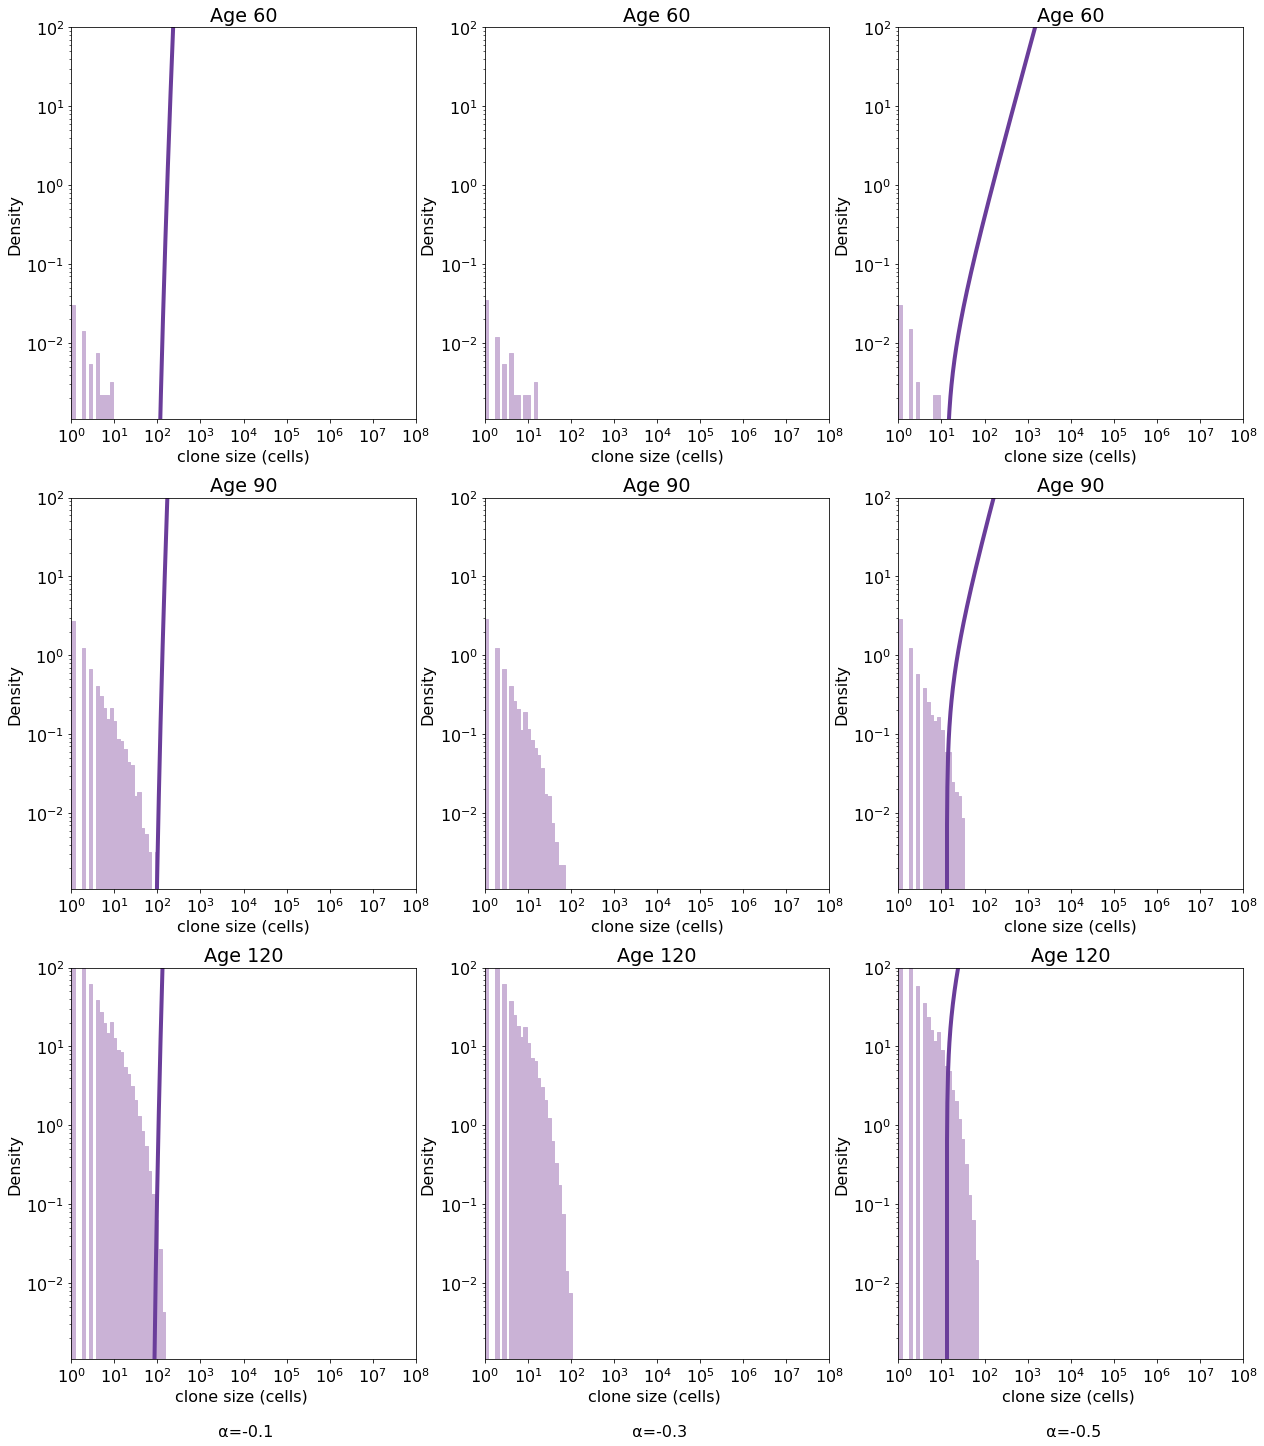

In [ ]:
density(1000, 0.15, 0.15*0.1)